In [1]:
!pip install e2cnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 5.1 MB/s eta 0:00:00


In [2]:
# Rotation Equivariant VAE for MNIST
# ===================================

# Cell 1: Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import os
from PIL import Image
from torchvision.utils import make_grid
from sklearn.manifold import TSNE
import e2cnn.nn as gnn
import e2cnn.gspaces as gspaces
from e2cnn.nn import GeometricTensor

# Set random seeds for reproducibility
def set_seed():
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Cell 2: Dataset Preparation - Creating rotated MNIST dataset
class RotatedMNIST(Dataset):
    def __init__(self, root, train=True, download=True, digits=[1, 2], angles=None):
        """
        Dataset class for rotated MNIST digits.
        
        Args:
            root: Root directory for the dataset
            train: Whether to use the training set (True) or test set (False)
            download: Whether to download the dataset if not present
            digits: List of digits to include (e.g., [1, 2])
            angles: List of rotation angles in degrees
        """
        self.mnist = datasets.MNIST(root=root, train=train, download=download, 
                                   transform=transforms.ToTensor())
        
        # Filter for specified digits
        digit_indices = [i for i, (_, label) in enumerate(self.mnist) if label in digits]
        self.mnist_subset = Subset(self.mnist, digit_indices)
        
        # Define rotation angles (in degrees)
        if angles is None:
            self.angles = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
        else:
            self.angles = angles
            
        print(f"Created dataset with {len(self.mnist_subset)} samples, each rotated to {len(self.angles)} angles")
        
    def __len__(self):
        return len(self.mnist_subset) * len(self.angles)
    
    def __getitem__(self, idx):
        # Determine original index and rotation
        original_idx = idx // len(self.angles)
        angle_idx = idx % len(self.angles)
        angle = self.angles[angle_idx]
        
        # Get original image and label
        img, label = self.mnist_subset[original_idx]
        
        # Convert to PIL for rotation
        img_pil = transforms.ToPILImage()(img)
        
        # Rotate image
        rotated_img = transforms.functional.rotate(img_pil, angle)
        
        # Center crop to 24x24
        cropped_img = transforms.functional.center_crop(rotated_img, 24)
        
        # Convert back to tensor
        rotated_tensor = transforms.ToTensor()(cropped_img)
        
        return rotated_tensor, label, angle

In [4]:
# Cell 3: Create dataloaders
def get_dataloaders(batch_size=128, digits=[1, 2]):
    # Create datasets
    train_dataset = RotatedMNIST(root='./data', train=True, download=True, digits=digits)
    test_dataset = RotatedMNIST(root='./data', train=False, download=True, digits=digits)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
    return train_loader, test_loader

In [5]:
# Cell 4: Visualize some samples from the dataset
def visualize_rotated_samples(dataset, num_samples=5, num_angles=12):
    fig, axes = plt.subplots(num_samples, num_angles, figsize=(15, 10))
    
    for i in range(num_samples):
        # Get the same digit at different rotations
        base_idx = i * num_angles
        for j in range(num_angles):
            img, label, angle = dataset[base_idx + j]
            axes[i, j].imshow(img.squeeze(), cmap='gray')
            axes[i, j].set_title(f"Digit: {label}, {angle}°")
            axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 160kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.03MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Created dataset with 12700 samples, each rotated to 12 angles
Created dataset with 2167 samples, each rotated to 12 angles


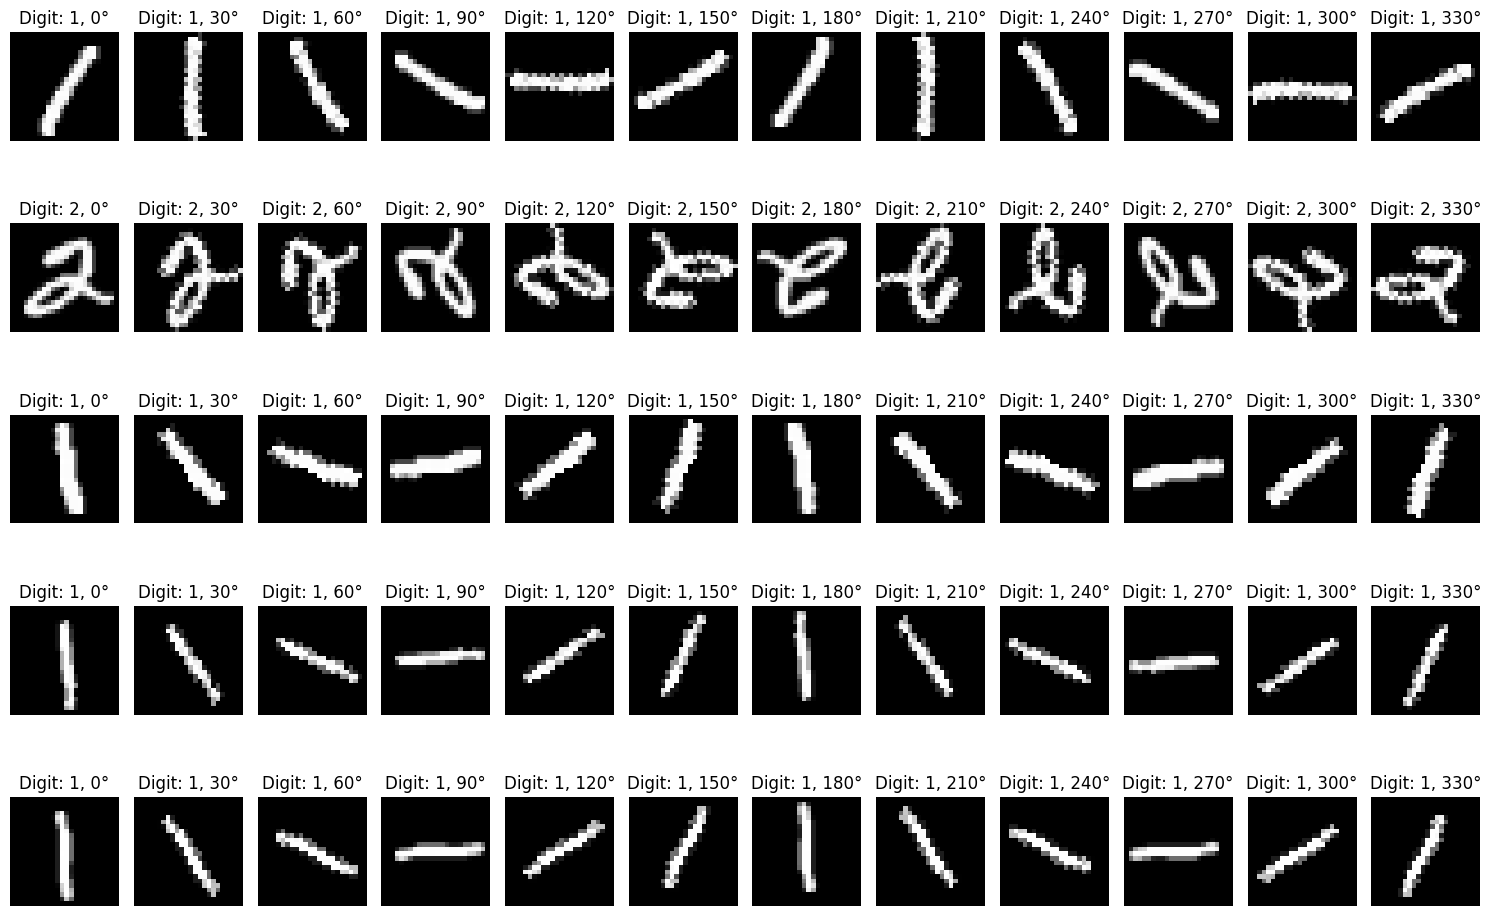

In [6]:
set_seed()
# Cell 5: Create and initialize the datasets
train_loader, test_loader = get_dataloaders(batch_size=128, digits=[1, 2])

# Visualize samples
train_dataset = train_loader.dataset
visualize_rotated_samples(train_dataset, num_samples=5, num_angles=12)

In [7]:
# Cell 6: Define e2cnn setup for proper rotation equivariance
def build_e2cnn_vae_blocks(num_rotations=12):
    """
    Build the e2cnn components for a rotation-equivariant VAE.
    """
    # Define the symmetry group (C12 for 12 rotations)
    r12_act = gspaces.Rot2dOnR2(N=num_rotations)
    
    # Input type: regular representation on the pixels (1 channel)
    in_type = gnn.FieldType(r12_act, [r12_act.trivial_repr] * 1)
    
    # Encoder layers
    # First layer
    out_type1 = gnn.FieldType(r12_act, [r12_act.regular_repr]*8)
    conv1 = gnn.R2Conv(in_type, out_type1, kernel_size=3, padding=1)
    bn1 = gnn.InnerBatchNorm(out_type1)
    relu1 = gnn.ReLU(out_type1)
    pool1 = gnn.PointwiseMaxPool(out_type1, kernel_size=2)
    
    # Second layer
    out_type2 = gnn.FieldType(r12_act, [r12_act.regular_repr]*16)
    conv2 = gnn.R2Conv(pool1.out_type, out_type2, kernel_size=3, padding=1)
    bn2 = gnn.InnerBatchNorm(out_type2)
    relu2 = gnn.ReLU(out_type2)
    pool2 = gnn.PointwiseMaxPool(out_type2, kernel_size=2)
    
    # Third layer
    out_type3 = gnn.FieldType(r12_act, [r12_act.regular_repr]*32)
    conv3 = gnn.R2Conv(pool2.out_type, out_type3, kernel_size=3, padding=1)
    bn3 = gnn.InnerBatchNorm(out_type3)
    relu3 = gnn.ReLU(out_type3)
    pool3 = gnn.PointwiseMaxPool(out_type3, kernel_size=2)
    
    # Group pooling (makes features invariant to rotation)
    invariant_map = gnn.GroupPooling(out_type3)
    
    # Calculate flattened size after pooling
    # After 3 pooling layers of kernel_size=2, the 28x28 image becomes 3x3
    # The number of channels is determined by out_type3
    flatten_dim = 32 * 3 * 3
    
    # Package all components
    encoder_blocks = {
        'r12_act': r12_act,
        'in_type': in_type,
        'conv1': conv1,
        'bn1': bn1,
        'relu1': relu1,
        'pool1': pool1,
        'conv2': conv2,
        'bn2': bn2,
        'relu2': relu2,
        'pool2': pool2,
        'conv3': conv3,
        'bn3': bn3,
        'relu3': relu3,
        'pool3': pool3,
        'invariant_map': invariant_map,
        'flatten_dim': flatten_dim
    }
    
    return encoder_blocks

In [8]:
# Cell 7: Define the e2cnn-based Equivariant VAE model
class EquivariantVAE(nn.Module):
    def __init__(self, latent_dim=16, num_rotations=12):
        super(EquivariantVAE, self).__init__()
        self.latent_dim = latent_dim
        self.num_rotations = num_rotations
        
        # Build e2cnn encoder blocks
        encoder_blocks = build_e2cnn_vae_blocks(num_rotations)
        
        # Store all the e2cnn components
        self.r12_act = encoder_blocks['r12_act']
        self.in_type = encoder_blocks['in_type']
        self.conv1 = encoder_blocks['conv1']
        self.bn1 = encoder_blocks['bn1']
        self.relu1 = encoder_blocks['relu1']
        self.pool1 = encoder_blocks['pool1']
        self.conv2 = encoder_blocks['conv2']
        self.bn2 = encoder_blocks['bn2']
        self.relu2 = encoder_blocks['relu2']
        self.pool2 = encoder_blocks['pool2']
        self.conv3 = encoder_blocks['conv3']
        self.bn3 = encoder_blocks['bn3']
        self.relu3 = encoder_blocks['relu3']
        self.pool3 = encoder_blocks['pool3']
        self.invariant_map = encoder_blocks['invariant_map']
        self.flatten_dim = encoder_blocks['flatten_dim']
        
        # Fully connected layers for latent space
        self.fc_mu = nn.Linear(self.flatten_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.flatten_dim, latent_dim)
        
        # Decoder (standard CNN-based decoder)
        self.decoder_input = nn.Linear(latent_dim, self.flatten_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 3, 3)),  # Changed from 128 to 32 to match e2cnn output
            
            nn.ConvTranspose2d(32, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        # Convert to GeometricTensor
        x = GeometricTensor(x, self.in_type)
        
        # Apply e2cnn layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Pool over group to get rotation invariant features
        x = self.invariant_map(x)
        
        # Extract features as ordinary tensor and flatten
        x = x.tensor
        x = x.view(x.size(0), -1)
        
        # Return mean and log-variance
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        # Reparameterization trick
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        # Decode from latent space to image
        x = self.decoder_input(z)
        x = self.decoder(x)  # Changed from 128 to 32
        return x
    
    def forward(self, x):
        # Forward pass
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [9]:
# Cell 8: Define the loss function with beta weighting for disentanglement
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    # Reconstruction loss (binary cross entropy)
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    # Total loss with beta parameter for disentanglement
    total_loss = recon_loss + beta * kl_loss
    
    return total_loss, recon_loss, kl_loss

In [10]:
# Cell 9: Training function
def train_vae(model, train_loader, optimizer, epoch, beta=1.0):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (data, _, _) in progress_bar:
        data = data.to(device)
        
        optimizer.zero_grad()
        # Forward pass
        recon_batch, mu, logvar = model(data)
        # Calculate loss
        loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        
        # Update progress bar
        progress_bar.set_description(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                                    f'({100. * batch_idx / len(train_loader):.0f}%)]')
    
    # Average losses
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon_loss = recon_loss_total / len(train_loader.dataset)
    avg_kl_loss = kl_loss_total / len(train_loader.dataset)
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f} | '
          f'Recon: {avg_recon_loss:.4f} | KL: {avg_kl_loss:.4f}')
    
    return avg_loss, avg_recon_loss, avg_kl_loss

In [11]:
# Cell 10: Evaluation function
def test_vae(model, test_loader, epoch, beta=1.0):
    model.eval()
    test_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    
    with torch.no_grad():
        for data, _, _ in test_loader:
            data = data.to(device)
            
            # Forward pass
            recon_batch, mu, logvar = model(data)
            
            # Calculate loss
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            # Update metrics
            test_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
    
    # Average losses
    avg_loss = test_loss / len(test_loader.dataset)
    avg_recon_loss = recon_loss_total / len(test_loader.dataset)
    avg_kl_loss = kl_loss_total / len(test_loader.dataset)
    
    print(f'====> Test set loss: {avg_loss:.4f} | '
          f'Recon: {avg_recon_loss:.4f} | KL: {avg_kl_loss:.4f}')
    
    return avg_loss, avg_recon_loss, avg_kl_loss

In [12]:
# Cell 11: Visualize reconstructions
def visualize_reconstructions(model, test_loader, num_examples=10):
    model.eval()
    with torch.no_grad():
        # Get a batch of test images
        data, labels, angles = next(iter(test_loader))
        data = data.to(device)
        
        # Reconstruct images
        recon_batch, _, _ = model(data)
        
        # Select num_examples images
        n = min(num_examples, data.size(0))
        comparison = torch.cat([data[:n], recon_batch[:n]])
        
        # Create grid and visualize
        grid = make_grid(comparison, nrow=n, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 4))
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.title('Original (top) vs Reconstructed (bottom)')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        return data[:n], recon_batch[:n], labels[:n], angles[:n]

In [13]:
# Cell 12: Visualize the latent space
def visualize_latent_space(model, test_loader, num_examples=500):
    model.eval()
    latent_vectors = []
    labels_list = []
    angles_list = []
    
    with torch.no_grad():
        for i, (data, labels, angles) in enumerate(test_loader):
            if i * test_loader.batch_size >= num_examples:
                break
                
            data = data.to(device)
            mu, _ = model.encode(data)
            
            latent_vectors.append(mu.cpu().numpy())
            labels_list.append(labels.numpy())
            angles_list.append(angles.numpy())
    
    # Concatenate all batches
    latent_vectors = np.concatenate(latent_vectors, axis=0)[:num_examples]
    labels = np.concatenate(labels_list, axis=0)[:num_examples]
    angles = np.concatenate(angles_list, axis=0)[:num_examples]
    
    # Perform t-SNE to reduce dimensionality to 2D
    tsne = TSNE(n_components=2, random_state=42)
    latent_tsne = tsne.fit_transform(latent_vectors)
    
    # Create figure with two subplots - one for digit, one for angle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot by digit label
    scatter1 = ax1.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                         c=labels, cmap='tab10', alpha=0.8, s=40)
    ax1.set_title('Latent Space (t-SNE) by Digit')
    ax1.set_xlabel('t-SNE Dimension 1')
    ax1.set_ylabel('t-SNE Dimension 2')
    ax1.grid(True, alpha=0.3)
    legend1 = ax1.legend(*scatter1.legend_elements(), title="Digits")
    ax1.add_artist(legend1)
    
    # Plot by rotation angle
    scatter2 = ax2.scatter(latent_tsne[:, 0], latent_tsne[:, 1], 
                         c=angles, cmap='hsv', alpha=0.8, s=40)
    ax2.set_title('Latent Space (t-SNE) by Rotation Angle')
    ax2.set_xlabel('t-SNE Dimension 1')
    ax2.set_ylabel('t-SNE Dimension 2')
    ax2.grid(True, alpha=0.3)
    cbar = plt.colorbar(scatter2, ax=ax2)
    cbar.set_label('Rotation Angle (degrees)')
    
    plt.tight_layout()
    plt.show()
    
    return latent_vectors, latent_tsne, labels, angles

In [14]:
# Cell 13: Latent space traversal
def latent_traversal(model, test_loader, dim_to_traverse=0, num_traversal_steps=10, range_val=(-3, 3)):
    """Visualize the effect of traversing along a specific latent dimension."""
    model.eval()
    
    # Get a random test image
    data, labels, angles = next(iter(test_loader))
    data = data[:1].to(device)  # Just take the first image
    
    # Encode the image to get its latent representation
    with torch.no_grad():
        mu, _ = model.encode(data)
        z = mu.clone()
    
    # Create traversal values
    traverse_values = np.linspace(range_val[0], range_val[1], num_traversal_steps)
    reconstructions = []
    
    # Generate reconstructions with traversal
    with torch.no_grad():
        for val in traverse_values:
            # Create a copy of the latent vector
            z_new = z.clone()
            
            # Modify the specific dimension
            z_new[0, dim_to_traverse] = val
            
            # Decode and save the reconstruction
            recon = model.decode(z_new)
            reconstructions.append(recon)
    
    # Stack the reconstructions
    stacked_recon = torch.cat(reconstructions)
    
    # Visualize
    grid = make_grid(stacked_recon, nrow=num_traversal_steps, normalize=True, pad_value=1)
    plt.figure(figsize=(15, 3))
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
    plt.title(f'Latent traversal along dimension {dim_to_traverse} from {range_val[0]} to {range_val[1]}')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [15]:
set_seed()
# Cell 14: Initialize model, optimizer and scheduler
latent_dim = 16
num_rotations = 12
beta = 1.0  # Start with standard VAE

# Initialize the e2cnn-based model
model = EquivariantVAE(latent_dim=latent_dim, num_rotations=num_rotations).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Print model summary
print(f"Model initialized with latent dimension: {latent_dim}")
print(f"Using {num_rotations} discrete rotations for equivariance")

/usr/local/lib/python3.10/dist-packages/e2cnn/nn/modules/r2_conv/basisexpansion_singleblock.py:80: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  full_mask[mask] = norms.to(torch.uint8)


Model initialized with latent dimension: 16
Using 12 discrete rotations for equivariance


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Beta annealing: current beta = 0.20


Train Epoch: 1 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:35<00:00, 33.10it/s]

====> Epoch: 1 Average loss: 106.6099 | Recon: 99.0550 | KL: 37.7744


====> Test set loss: 79.0477 | Recon: 71.2552 | KL: 38.9626
Beta annealing: current beta = 0.40


Train Epoch: 2 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.68it/s]

====> Epoch: 2 Average loss: 84.0729 | Recon: 71.1941 | KL: 32.1969


====> Test set loss: 81.5276 | Recon: 68.7744 | KL: 31.8828
Beta annealing: current beta = 0.60


Train Epoch: 3 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.88it/s]

====> Epoch: 3 Average loss: 87.0240 | Recon: 70.3065 | KL: 27.8624


====> Test set loss: 85.5590 | Recon: 68.6976 | KL: 28.1024
Beta annealing: current beta = 0.80


Train Epoch: 4 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.71it/s]

====> Epoch: 4 Average loss: 90.7115 | Recon: 70.8202 | KL: 24.8641


====> Test set loss: 89.4233 | Recon: 70.0232 | KL: 24.2501
Beta annealing: current beta = 1.00


Train Epoch: 5 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:33<00:00, 35.09it/s]

====> Epoch: 5 Average loss: 94.3539 | Recon: 71.7422 | KL: 22.6117


====> Test set loss: 94.0493 | Recon: 71.4962 | KL: 22.5532
Beta annealing: current beta = 1.20


Train Epoch: 6 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:33<00:00, 35.23it/s]

====> Epoch: 6 Average loss: 97.7982 | Recon: 72.9025 | KL: 20.7464


====> Test set loss: 96.7562 | Recon: 71.5918 | KL: 20.9703
Beta annealing: current beta = 1.40


Train Epoch: 7 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.80it/s]

====> Epoch: 7 Average loss: 101.0185 | Recon: 74.1770 | KL: 19.1725


====> Test set loss: 99.3713 | Recon: 73.2756 | KL: 18.6398
Beta annealing: current beta = 1.60


Train Epoch: 8 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.56it/s]

====> Epoch: 8 Average loss: 103.1476 | Recon: 74.4010 | KL: 17.9667


====> Test set loss: 101.9833 | Recon: 73.4846 | KL: 17.8117
Beta annealing: current beta = 1.80


Train Epoch: 9 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.81it/s]

====> Epoch: 9 Average loss: 106.2796 | Recon: 75.8124 | KL: 16.9262


====> Test set loss: 104.8899 | Recon: 74.5022 | KL: 16.8821
Beta annealing: current beta = 2.00


Train Epoch: 10 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.69it/s]

====> Epoch: 10 Average loss: 109.1231 | Recon: 77.2076 | KL: 15.9578


====> Test set loss: 108.1861 | Recon: 76.0911 | KL: 16.0475
Visualizing reconstructions at epoch 10


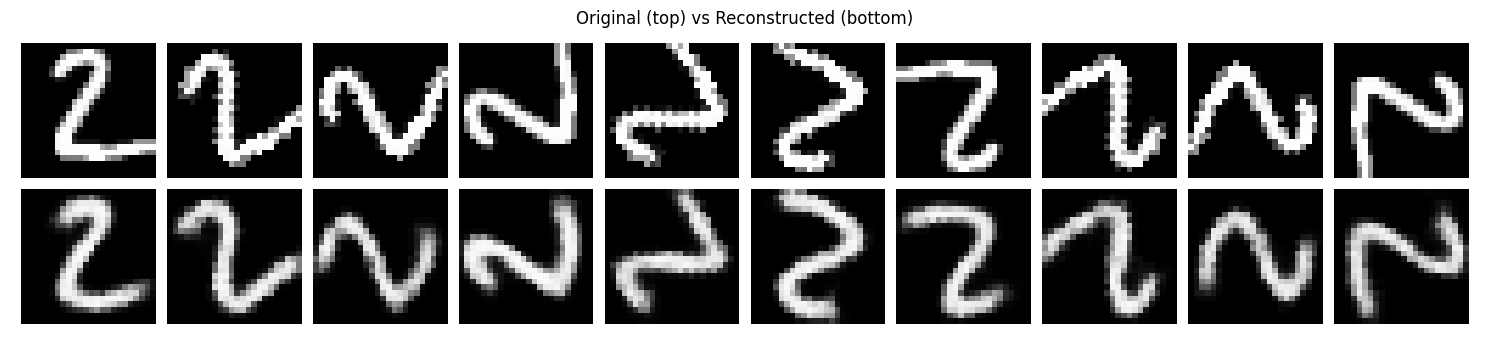

Train Epoch: 11 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.66it/s]

====> Epoch: 11 Average loss: 108.7387 | Recon: 77.1661 | KL: 15.7863


====> Test set loss: 107.9676 | Recon: 76.6745 | KL: 15.6465


Train Epoch: 12 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.50it/s]

====> Epoch: 12 Average loss: 108.4749 | Recon: 77.0441 | KL: 15.7154


====> Test set loss: 107.2397 | Recon: 76.1286 | KL: 15.5555


Train Epoch: 13 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.35it/s]

====> Epoch: 13 Average loss: 108.1703 | Recon: 76.9304 | KL: 15.6200


====> Test set loss: 107.4007 | Recon: 75.8349 | KL: 15.7829


Train Epoch: 14 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.52it/s]

====> Epoch: 14 Average loss: 107.4685 | Recon: 76.2575 | KL: 15.6055


====> Test set loss: 106.4073 | Recon: 75.0930 | KL: 15.6571


Train Epoch: 15 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.63it/s]


====> Epoch: 15 Average loss: 107.2881 | Recon: 76.1404 | KL: 15.5739
====> Test set loss: 106.4974 | Recon: 75.2821 | KL: 15.6077


Train Epoch: 16 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.51it/s]

====> Epoch: 16 Average loss: 107.1999 | Recon: 76.0742 | KL: 15.5628


====> Test set loss: 106.3115 | Recon: 75.0664 | KL: 15.6226


Train Epoch: 17 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.74it/s]

====> Epoch: 17 Average loss: 107.1062 | Recon: 75.9972 | KL: 15.5545


====> Test set loss: 106.1165 | Recon: 74.7133 | KL: 15.7016


Train Epoch: 18 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:33<00:00, 35.35it/s]

====> Epoch: 18 Average loss: 106.9472 | Recon: 75.9185 | KL: 15.5144


====> Test set loss: 106.0676 | Recon: 74.6754 | KL: 15.6961


Train Epoch: 19 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.35it/s]

====> Epoch: 19 Average loss: 106.8485 | Recon: 75.8709 | KL: 15.4888


====> Test set loss: 105.9908 | Recon: 74.8697 | KL: 15.5605


Train Epoch: 20 [95200/152400 (100%)]: 100%|██████████| 1191/1191 [00:34<00:00, 34.69it/s]

====> Epoch: 20 Average loss: 106.4807 | Recon: 75.5141 | KL: 15.4833


====> Test set loss: 105.5859 | Recon: 74.4667 | KL: 15.5596
Visualizing reconstructions at epoch 20


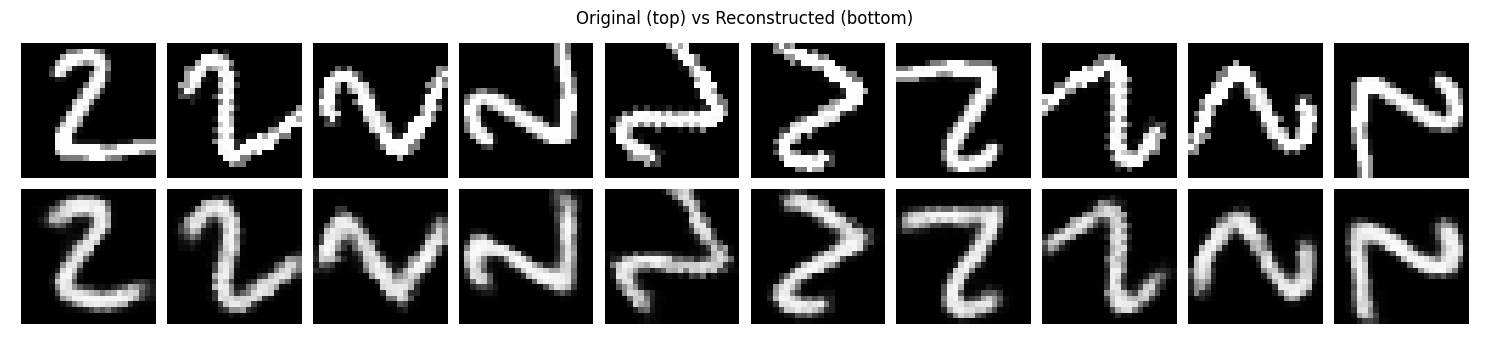

In [16]:
set_seed()
# Cell 15: Training loop
num_epochs = 20
train_losses = []
test_losses = []
recon_losses = []
kl_losses = []

# Beta annealing (helps with disentanglement)
beta_start = 0.0
beta_end = 2.0
beta_steps = 10
beta_increment = (beta_end - beta_start) / beta_steps

# Create results folder
if not os.path.exists('./results'):
    os.makedirs('./results')

for epoch in range(1, num_epochs + 1):
    # Update beta for annealing (first beta_steps epochs)
    if epoch <= beta_steps:
        beta = beta_start + epoch * beta_increment
        print(f"Beta annealing: current beta = {beta:.2f}")
    
    # Train and test
    train_loss, train_recon_loss, train_kl_loss = train_vae(model, train_loader, optimizer, epoch, beta)
    test_loss, test_recon_loss, test_kl_loss = test_vae(model, test_loader, epoch, beta)
    
    # Save metrics
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    recon_losses.append(test_recon_loss)
    kl_losses.append(test_kl_loss)
    
    # Update learning rate scheduler
    scheduler.step(test_loss)
    
    # Visualize reconstructions every 10 epochs
    if epoch % 10 == 0:
        print(f"Visualizing reconstructions at epoch {epoch}")
        visualize_reconstructions(model, test_loader)
        
        # Save model checkpoint
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss
        }, f'./results/model_epoch_{epoch}.pth')

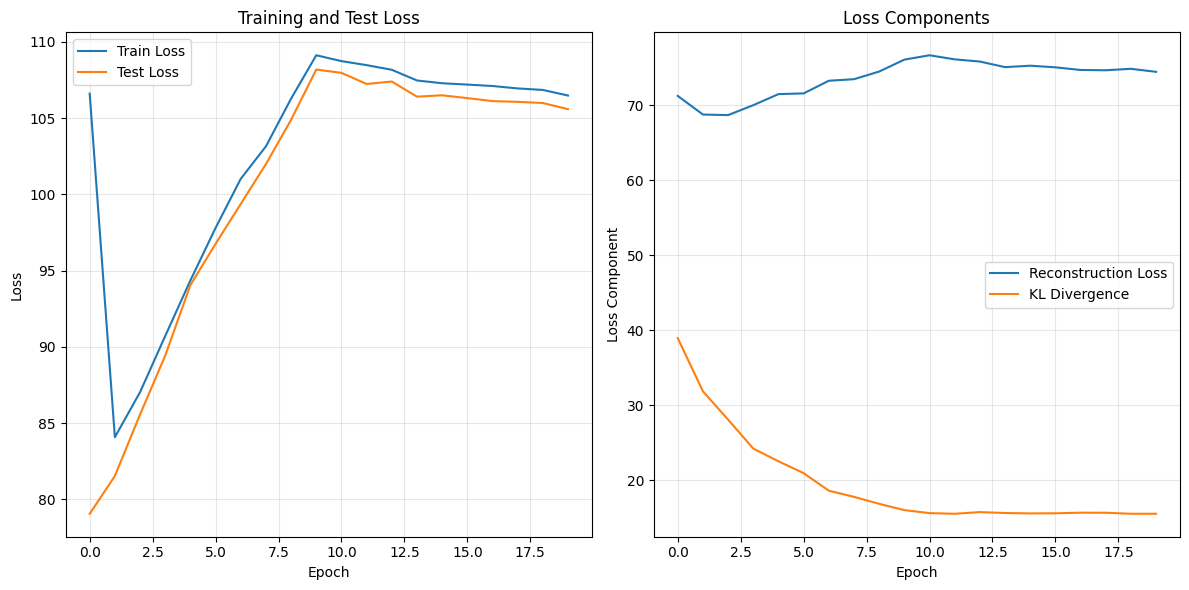

Visualizing final reconstructions


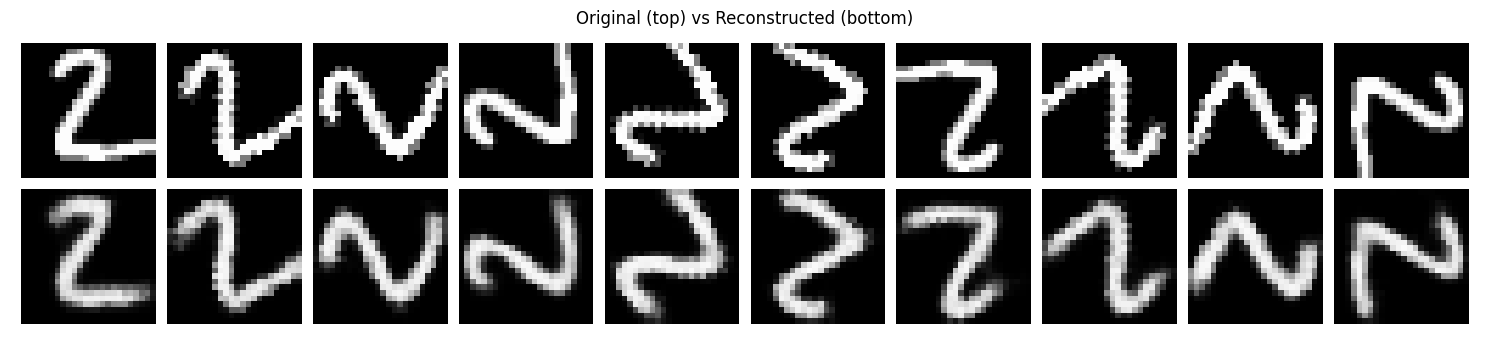

Visualizing latent space (t-SNE)


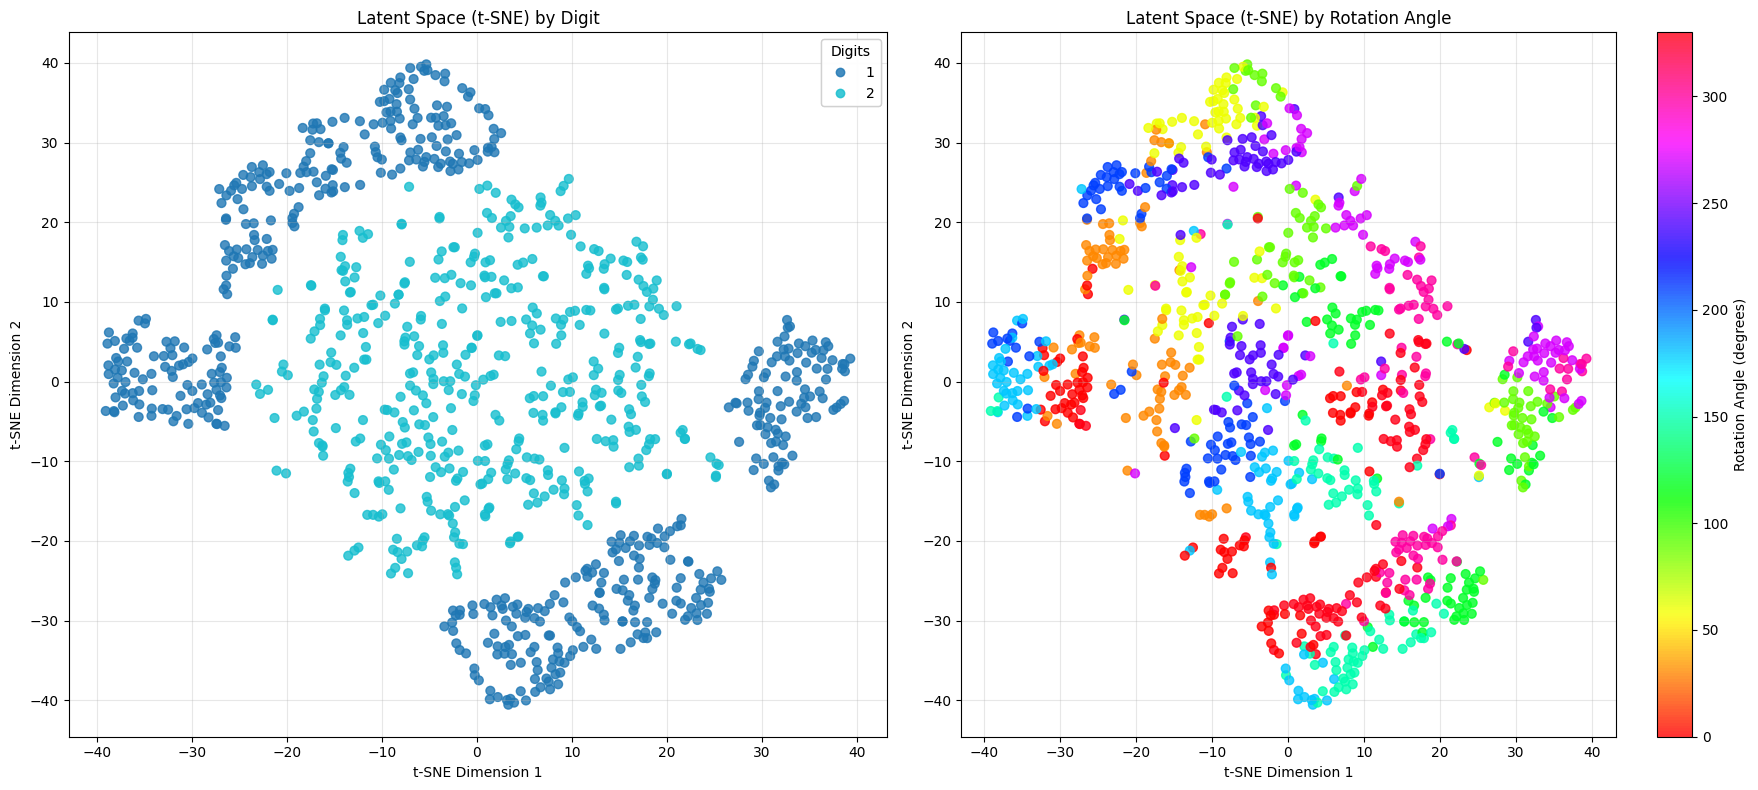

Visualizing latent traversals


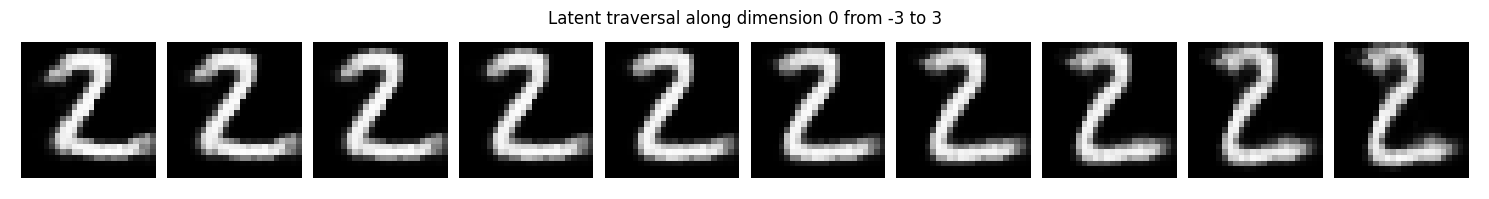

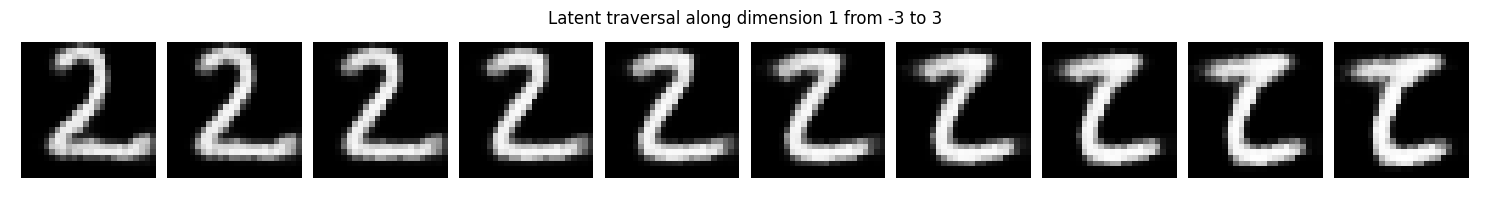

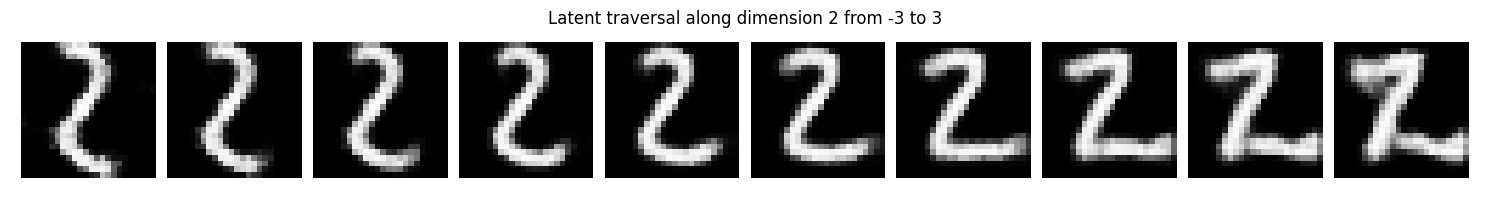

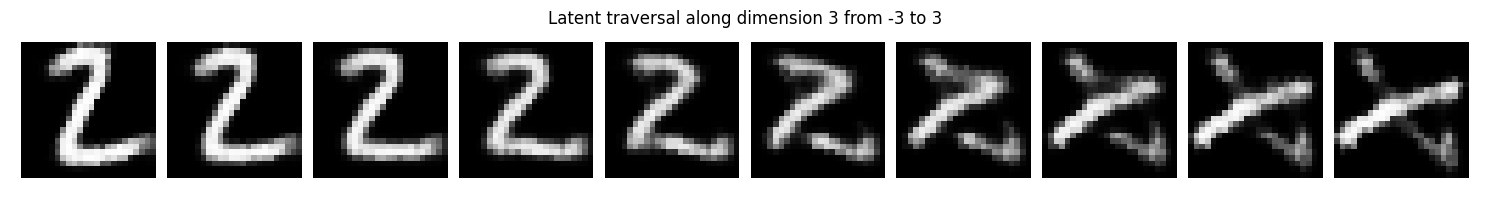

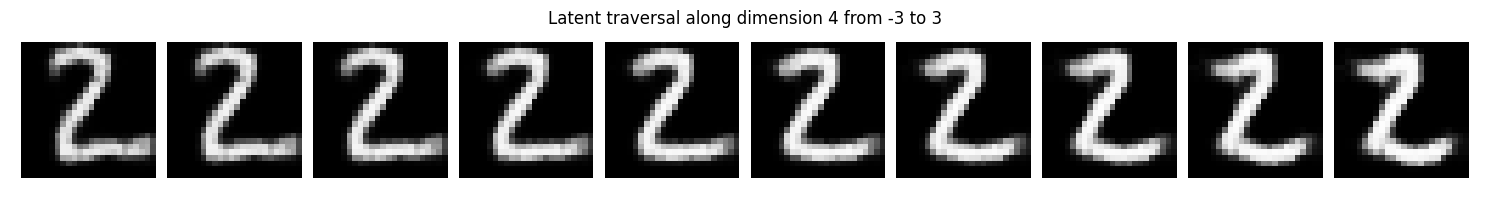

In [17]:
set_seed()
# Cell 16: Visualize training curves
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(recon_losses, label='Reconstruction Loss')
plt.plot(kl_losses, label='KL Divergence')
plt.xlabel('Epoch')
plt.ylabel('Loss Component')
plt.title('Loss Components')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/training_curves.png')
plt.show()

# Cell 17: Visualize final reconstructions
print("Visualizing final reconstructions")
originals, reconstructions, labels, angles = visualize_reconstructions(model, test_loader, num_examples=10)

# Cell 18: Visualize latent space
print("Visualizing latent space (t-SNE)")
latent_vectors, latent_tsne, labels, angles = visualize_latent_space(model, test_loader, num_examples=1000)

# Cell 19: Latent traversals for multiple dimensions
print("Visualizing latent traversals")
for dim in range(5):  # Show traversals for first 5 dimensions
    latent_traversal(model, test_loader, dim_to_traverse=dim)

Visualizing e2cnn equivariant feature maps


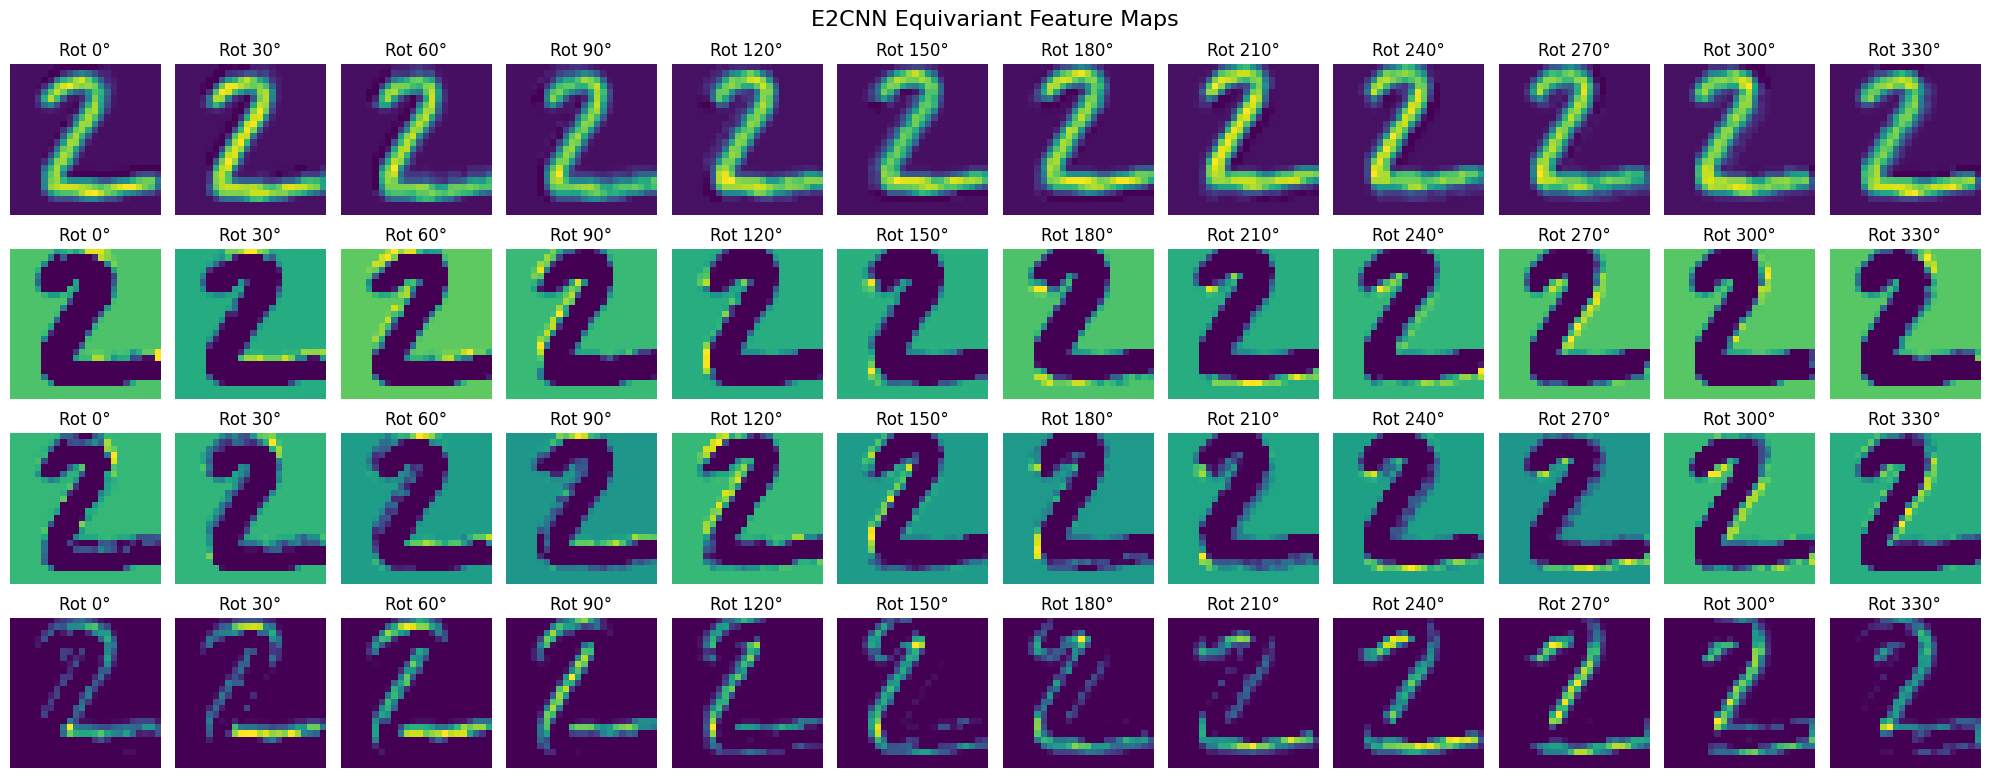

In [18]:
# Cell 19b: Visualize e2cnn feature maps
def visualize_e2cnn_features(model, test_loader):
    """Visualize the equivariant feature maps from the e2cnn encoder"""
    model.eval()
    with torch.no_grad():
        # Get a sample image
        data, labels, angles = next(iter(test_loader))
        data = data[:1].to(device)  # Just one image
        
        # Convert to GeometricTensor
        x = GeometricTensor(data, model.in_type)
        
        # Get feature maps after first layer
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu1(x)
        
        # Extract features to visualize
        feature_maps = x.tensor
        
        # Calculate feature dimensions
        batch_size, channels, h, w = feature_maps.shape
        channels_per_rotation = channels // model.num_rotations
        
        # Reshape to separate group and feature dimensions
        feature_maps = feature_maps.reshape(batch_size, channels_per_rotation, model.num_rotations, h, w)
        
        # Plot a subset of feature maps
        fig, axes = plt.subplots(4, model.num_rotations, figsize=(20, 8))
        for i in range(4):  # Show first 4 features
            for j in range(model.num_rotations):  # All rotations
                axes[i, j].imshow(feature_maps[0, i, j].cpu(), cmap='viridis')
                axes[i, j].axis('off')
                axes[i, j].set_title(f'Rot {j*30}°')
                
        plt.suptitle('E2CNN Equivariant Feature Maps', fontsize=16)
        plt.tight_layout()
        plt.savefig('./results/e2cnn_features.png')
        plt.show()

print("Visualizing e2cnn equivariant feature maps")
visualize_e2cnn_features(model, test_loader)

Generating new digits from random latent vectors


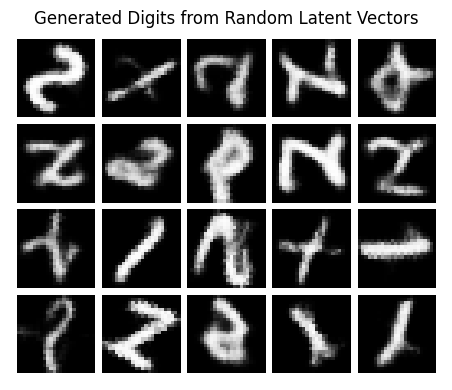

Visualizing latent space interpolation


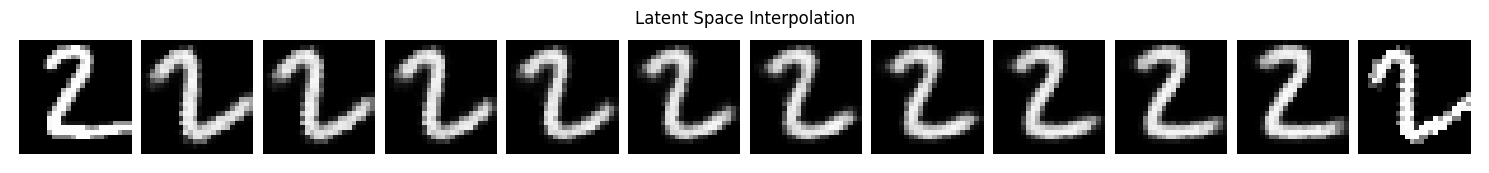

Saved final model to ./results/final_model.pth


In [19]:
# Cell 20: Generate new digits from the latent space
def generate_from_latent(model, num_samples=10):
    """Generate new digits by sampling from the latent space."""
    model.eval()
    
    with torch.no_grad():
        # Sample from the latent space (standard normal distribution)
        z = torch.randn(num_samples, model.latent_dim).to(device)
        
        # Decode to get generated images
        generated = model.decode(z)
        
        # Visualize
        grid = make_grid(generated, nrow=5, normalize=True, pad_value=1)
        plt.figure(figsize=(10, 4))
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.title('Generated Digits from Random Latent Vectors')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
        return generated

print("Generating new digits from random latent vectors")
generated_digits = generate_from_latent(model, num_samples=20)

# Cell 21: Interpolation in the latent space
def latent_space_interpolation(model, test_loader, num_steps=10):
    """Interpolate between two random digits in the latent space."""
    model.eval()
    
    # Get two random test images
    data, labels, angles = next(iter(test_loader))
    img1 = data[0:1].to(device)
    img2 = data[1:2].to(device)
    
    # Encode to get latent vectors
    with torch.no_grad():
        z1, _ = model.encode(img1)
        z2, _ = model.encode(img2)
        
        # Interpolate between the two latent vectors
        alphas = np.linspace(0, 1, num_steps)
        interpolations = []
        
        for alpha in alphas:
            z_interp = alpha * z1 + (1 - alpha) * z2
            recon = model.decode(z_interp)
            interpolations.append(recon)
        
        # Add the original images for comparison
        comparison = torch.cat([img1, *interpolations, img2])
        
        # Visualize
        grid = make_grid(comparison, nrow=num_steps+2, normalize=True, pad_value=1)
        plt.figure(figsize=(15, 3))
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.title('Latent Space Interpolation')
        plt.axis('off')
        plt.tight_layout()
        plt.savefig('./results/interpolation.png')
        plt.show()

print("Visualizing latent space interpolation")
latent_space_interpolation(model, test_loader, num_steps=10)

# Cell 22: Save the final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'latent_dim': latent_dim,
    'num_rotations': num_rotations,
    'beta': beta
}, './results/final_model.pth')

print("Saved final model to ./results/final_model.pth")


Analyzing rotation equivariance...


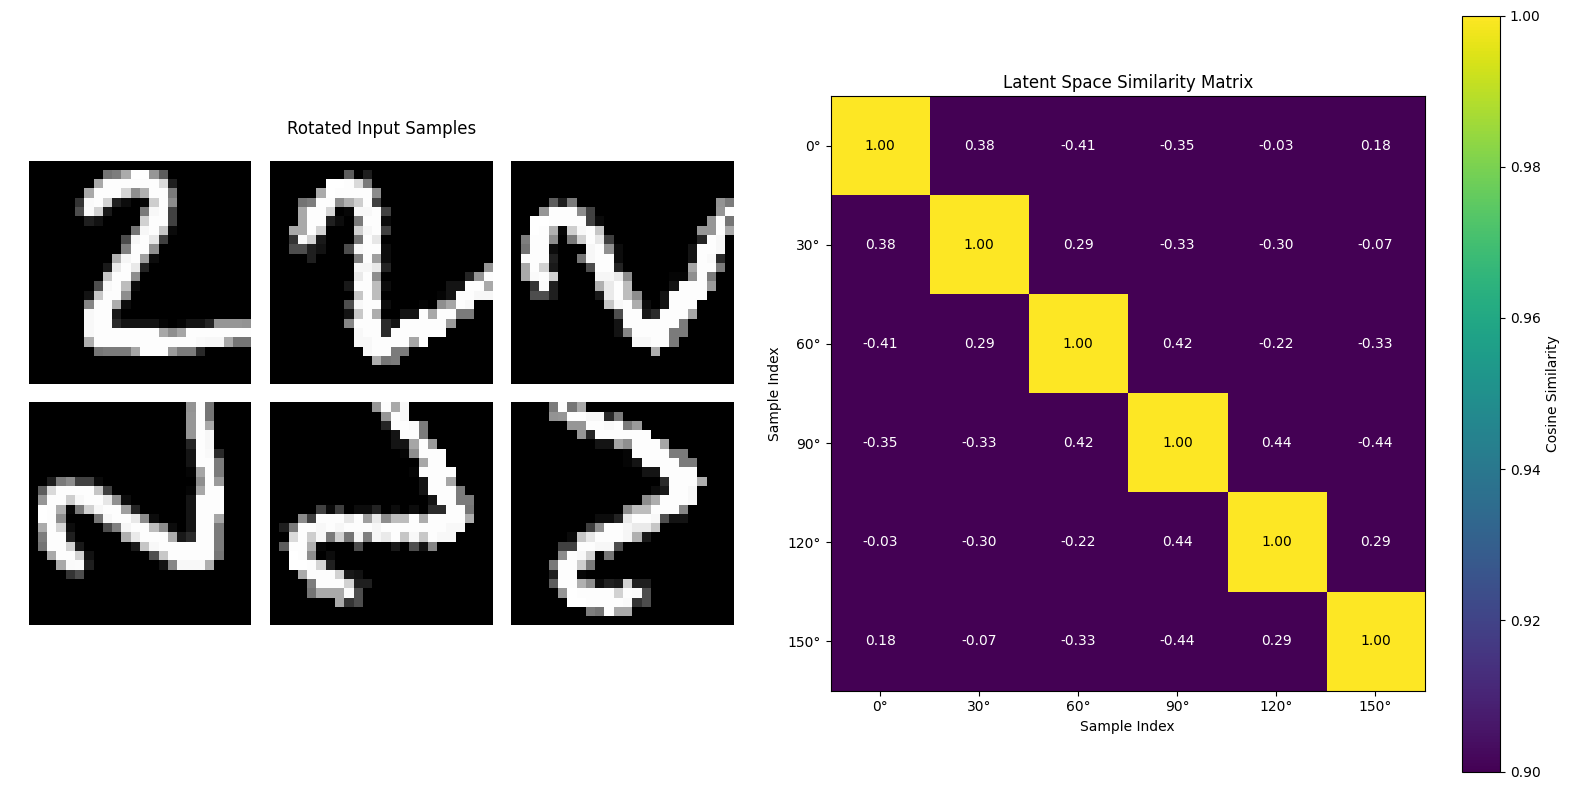

Average similarity between different rotations: -0.0313
Higher values indicate better rotation equivariance/invariance

Notebook completed successfully!


In [20]:
# Cell 23: Analysis of rotation equivariance
def analyze_rotation_equivariance(model, test_loader):
    """Analyze how well the model handles rotations by comparing latent representations"""
    model.eval()
    
    with torch.no_grad():
        # Get a batch of test images
        data_batch, labels, original_angles = next(iter(test_loader))
        
        # Select a single image
        img_idx = 0
        base_img = data_batch[img_idx:img_idx+1].to(device)
        base_label = labels[img_idx]
        
        # Find all rotations of this same digit in the batch
        same_digit_indices = [i for i, label in enumerate(labels) if label == base_label]
        
        if len(same_digit_indices) < 6:
            print("Not enough samples of the same digit found. Trying another batch...")
            return analyze_rotation_equivariance(model, test_loader)
        
        # Take a subset of the rotations (6 different angles)
        selected_indices = same_digit_indices[:6]
        rotation_samples = data_batch[selected_indices].to(device)
        rotation_angles = [original_angles[i] for i in selected_indices]
        
        # Encode the samples to get latent representations
        latent_vectors = []
        for img in rotation_samples:
            mu, _ = model.encode(img.unsqueeze(0))
            latent_vectors.append(mu.cpu().numpy())
        
        # Calculate pairwise cosine similarities between latent vectors
        from sklearn.metrics.pairwise import cosine_similarity
        latent_vectors = np.vstack(latent_vectors)
        similarities = cosine_similarity(latent_vectors)
        
        # Visualize
        plt.figure(figsize=(16, 8))
        
        # 1. Show the rotated images
        plt.subplot(1, 2, 1)
        grid = make_grid(rotation_samples, nrow=3, normalize=True, pad_value=1)
        plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)), cmap='gray')
        plt.title('Rotated Input Samples')
        plt.axis('off')
        
        # 2. Show the similarity matrix
        plt.subplot(1, 2, 2)
        plt.imshow(similarities, cmap='viridis', vmin=0.9, vmax=1.0)
        plt.colorbar(label='Cosine Similarity')
        plt.title('Latent Space Similarity Matrix')
        plt.xlabel('Sample Index')
        plt.ylabel('Sample Index')
        
        # Add rotation angles as labels
        angles_labels = [f"{angle}°" for angle in rotation_angles]
        plt.xticks(range(len(rotation_angles)), angles_labels)
        plt.yticks(range(len(rotation_angles)), angles_labels)
        
        # Add text annotations
        for i in range(len(similarities)):
            for j in range(len(similarities)):
                plt.text(j, i, f"{similarities[i, j]:.2f}", 
                         ha="center", va="center", 
                         color="white" if similarities[i, j] < 0.95 else "black")
        
        plt.tight_layout()
        plt.savefig('./results/rotation_equivariance_analysis.png')
        plt.show()
        
        # Print average similarity
        avg_sim = (similarities.sum() - len(similarities)) / (len(similarities)**2 - len(similarities))
        print(f"Average similarity between different rotations: {avg_sim:.4f}")
        print("Higher values indicate better rotation equivariance/invariance")

print("\nAnalyzing rotation equivariance...")
analyze_rotation_equivariance(model, test_loader)

print("\nNotebook completed successfully!")